In [66]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm

import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# 데이터 로드
data = pd.read_csv('./datasets/train.csv')
data = data.loc[data.id != 'TRAIN_2143', :]
data['path'] = data['path'].map(lambda x : x.replace('./', './datasets/'))
data.reset_index(drop=True, inplace=True)

In [68]:
labels = torch.tensor(data['label']).unsqueeze(1)

In [69]:
def make_mel(data, max_len = None):

    n_fft = 1024
    win_length = 1024
    hop_length = 128
    n_mels = 128
    data_features = []
    features_max = []

    for idx in tqdm(range(0, len(data))):
        path = data.path[idx]
        label = data.label[idx]

        waveform, sr = librosa.load(path)

        # features
        stft = np.abs(librosa.stft(waveform, n_fft=n_fft, win_length=win_length, hop_length=hop_length))
        feature = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

        data_features.append(torch.tensor(feature))
        features_max.append(feature.shape[1])

    max_len = max(features_max) if max_len is None else max_len
    print(max_len)

    tensor_features = []
    for idx in data_features:
        # Padding
        audio_length = idx.shape[1]
        padding_length = max_len - audio_length
        padded_features = torch.nn.functional.pad(idx, (0, padding_length), value=0)
        tensor_features.append(padded_features)
    tensor_features = torch.stack(tensor_features)
    tensor_features = tensor_features.float()

    return tensor_features

In [70]:
mel = make_mel(data, max_len = None)

100%|██████████| 5000/5000 [00:52<00:00, 94.67it/s] 


840


In [71]:
def make_mfcc(data, max_len = None):

    n_fft = 1024
    hop_length = 128
    n_mels = 40
    data_features = []
    features_max = []

    for idx in tqdm(range(0, len(data))):
        path = data.path[idx]
        label = data.label[idx]

        waveform, sr = librosa.load(path)
        # features
        feature = librosa.feature.mfcc(y=waveform, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mels)
        feature = (feature - feature.mean()) / feature.std()
        data_features.append(torch.tensor(feature))
        features_max.append(feature.shape[1])

    max_len = max(features_max) if max_len is None else max_len
    print(max_len)

    tensor_features = []
    for idx in data_features:
        # Padding
        audio_length = idx.shape[1]
        padding_length = max_len - audio_length
        padded_features = torch.nn.functional.pad(idx, (0, padding_length), value=0)
        tensor_features.append(padded_features)
    tensor_features = torch.stack(tensor_features)
    tensor_features = tensor_features.float()

    return tensor_features

In [72]:
mfcc = make_mfcc(data, max_len = None)

100%|██████████| 5000/5000 [00:46<00:00, 108.16it/s]


840


In [73]:
def make_p_features(waveform, sr):

    # Zero Crossing Rate 추출
    zcr = librosa.feature.zero_crossing_rate(y=waveform)
    zcr = torch.tensor([zcr.mean(), zcr.std(), zcr.max(), zcr.min()])

    # Pitch 추출
    pitch, magnitudes = librosa.core.piptrack(y=waveform, sr=sr)
    pitch = torch.tensor([pitch.mean(), pitch.std(), pitch.max(), pitch.min()])

    # Duration 추출
    duration = librosa.get_duration(y=waveform, sr=sr)
    duration = torch.tensor([duration])

    # Energy 추출
    energy = librosa.feature.rms(y=waveform)
    energy = torch.tensor([energy.mean(), energy.std(), energy.max(), energy.min()])

    p_features = torch.cat([zcr, pitch, duration, energy])
    return p_features

def make_features(data):

    tensor_features = []

    for idx in tqdm(range(0, len(data))):
        path = data.path[idx]
        label = data.label[idx]
        waveform, sr = librosa.load(path)
        tensor_features.append(make_p_features(waveform, sr))

    tensor_features = torch.stack(tensor_features)
    tensor_features = tensor_features.float()

    return tensor_features

In [74]:
features = make_features(data)

100%|██████████| 5000/5000 [00:49<00:00, 100.51it/s]


### MEL

In [75]:
mel_features = torch.cat([mel.mean(axis=2), mel.max(axis=2)[0], mel.min(axis=2)[0]],axis=1)

data_adj = torch.cat([mel_features, labels],axis=1)
data_adj = pd.DataFrame(data_adj.numpy())
data_adj

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,384
0,0.010777,0.009003,0.011824,0.014592,0.015072,0.013814,0.016550,0.018827,0.017903,0.011376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.013768,0.009638,0.008904,0.011403,0.017419,0.020735,0.019970,0.021260,0.020689,0.012930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.012641,0.010522,0.011658,0.014023,0.024459,0.028240,0.027528,0.025823,0.025768,0.036745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.004381,0.009376,0.013525,0.020246,0.020958,0.012275,0.014074,0.016263,0.018334,0.019443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.007574,0.006126,0.008742,0.014279,0.020556,0.022697,0.019158,0.020804,0.028778,0.027367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.005637,0.013014,0.018554,0.021319,0.019157,0.018168,0.023682,0.022535,0.021862,0.021621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4996,0.012834,0.010231,0.012440,0.015846,0.015815,0.012368,0.014253,0.020534,0.024637,0.030983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.014513,0.009764,0.008124,0.010156,0.019917,0.019969,0.014622,0.017568,0.020090,0.029205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4998,0.013106,0.011560,0.014754,0.019470,0.019046,0.014725,0.018265,0.023855,0.027624,0.018826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
result = tsne.fit_transform(data_adj.iloc[:,:-1])
result.shape
result_df = pd.DataFrame(result, columns=['com1', 'com2'])
result_df['label'] = data_adj.iloc[:,-1]
result_df.head(5)

,com1,com2,label
0,-71.990082,-0.700163,1.0
1,-69.014641,3.151567,2.0
2,17.219387,-18.744596,4.0
3,-3.187696,-20.810541,5.0
4,36.330101,-20.506413,4.0


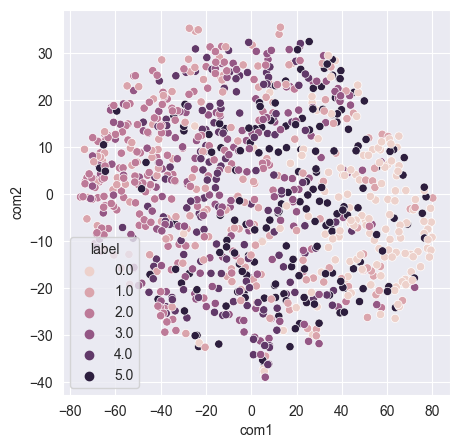

In [77]:
sns.set_palette('deep')
plt.figure(figsize=(5,5))
sns.scatterplot(x='com1', y='com2', hue='label', data=result_df.iloc[:1000,:])
plt.show()

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(data_adj.iloc[:,:-1])
result_df = pd.DataFrame(result, columns=['pca1', 'pca2'])
result_df['label'] = data_adj.iloc[:,-1]
result_df.head(5)

,pca1,pca2,label
0,-2.986018,0.354735,1.0
1,-3.015410,0.263634,2.0
2,-0.603234,0.081489,4.0
3,-1.041757,0.207034,5.0
4,0.421152,-0.814372,4.0


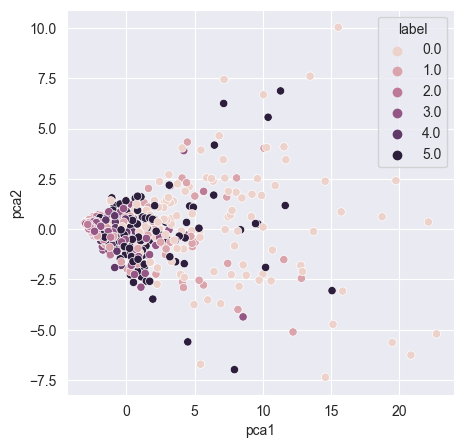

In [79]:
sns.set_palette('deep')
plt.figure(figsize=(5,5))
sns.scatterplot(x='pca1', y='pca2', hue='label', data=result_df.iloc[:1000,:])
plt.show()

### MFCC

In [80]:
mfcc_features = torch.cat([mfcc.mean(axis=2), mfcc.max(axis=2)[0], mfcc.min(axis=2)[0]],axis=1)

data_adj = torch.cat([mfcc_features, labels],axis=1)
data_adj = pd.DataFrame(data_adj.numpy())
data_adj

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,-2.880684,0.866069,0.093114,0.398572,-0.057616,0.251087,-0.071916,0.143121,-0.021540,0.093245,...,-0.075184,0.000000,-0.082597,-0.002218,-0.098831,-0.038233,-0.112500,-0.031528,-0.129563,1.0
1,-3.152621,0.850985,0.089030,0.541651,-0.055090,0.323305,-0.125417,0.197335,-0.060463,0.101920,...,-0.065302,-0.007281,-0.106952,-0.010198,-0.134274,-0.030194,-0.143614,-0.073856,-0.076709,2.0
2,-3.457761,1.038000,0.165186,0.457796,-0.072724,0.214581,-0.051953,0.105889,-0.061913,0.082364,...,-0.056736,-0.013243,-0.093185,-0.076981,-0.088000,-0.055670,-0.183804,-0.099869,-0.103251,4.0
3,-2.748362,0.811550,0.222943,0.277651,0.039299,0.072548,0.030913,0.072703,-0.006462,0.044058,...,-0.200035,-0.117260,-0.131677,-0.082083,-0.143459,-0.056397,-0.068807,-0.132414,-0.160274,5.0
4,-2.235916,0.694325,0.156918,0.241040,0.074970,0.060531,-0.012149,0.032468,-0.023995,0.020715,...,-0.106703,-0.026237,-0.052588,-0.069140,-0.131113,-0.114135,-0.106536,-0.152731,-0.072700,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-3.442756,0.990741,0.219016,0.408050,0.014667,0.260964,-0.025356,0.130639,-0.004250,0.051938,...,-0.058873,-0.043713,-0.096347,-0.055711,-0.080486,0.000000,-0.114649,-0.055450,-0.058486,5.0
4996,-2.830348,0.844609,-0.006563,0.287040,-0.059258,0.107692,0.069912,0.030098,-0.011518,0.106782,...,-0.222850,-0.263261,-0.397726,-0.167153,-0.217445,-0.122291,-0.067870,-0.155599,-0.086880,0.0
4997,-2.636767,0.785289,0.126148,0.336380,-0.015115,0.212729,-0.050160,0.084520,-0.024732,0.043050,...,-0.082396,-0.011170,-0.089330,-0.019044,-0.118740,-0.111571,-0.096236,-0.040027,-0.051725,1.0
4998,-3.855157,1.098101,0.161540,0.512366,-0.055540,0.320677,-0.081475,0.159705,0.017696,0.109704,...,-0.051179,-0.001061,-0.100783,-0.028672,-0.101339,-0.040844,-0.073846,-0.046285,-0.162434,1.0


In [81]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
result = tsne.fit_transform(data_adj.iloc[:,:-1])
result.shape
result_df = pd.DataFrame(result, columns=['com1', 'com2'])
result_df['label'] = data_adj.iloc[:,-1]
result_df.head(5)

,com1,com2,label
0,-27.568611,-20.904751,1.0
1,-58.348885,10.448072,2.0
2,-6.878634,21.787029,4.0
3,-5.082805,-19.560415,5.0
4,-3.372071,-39.988857,4.0


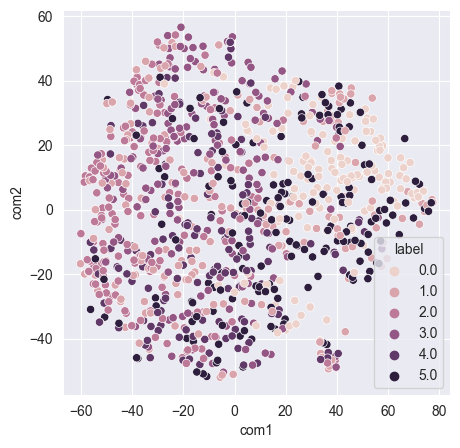

In [82]:
sns.set_palette('deep')
plt.figure(figsize=(5,5))
sns.scatterplot(x='com1', y='com2', hue='label', data=result_df.iloc[:1000,:])
plt.show()

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(data_adj.iloc[:,:-1])
result_df = pd.DataFrame(result, columns=['pca1', 'pca2'])
result_df['label'] = data_adj.iloc[:,-1]
result_df.head(5)

,pca1,pca2,label
0,-0.919871,-0.340694,1.0
1,-1.427448,-0.022918,2.0
2,-0.250271,0.435847,4.0
3,0.087085,-0.271862,5.0
4,-0.333328,-0.941778,4.0


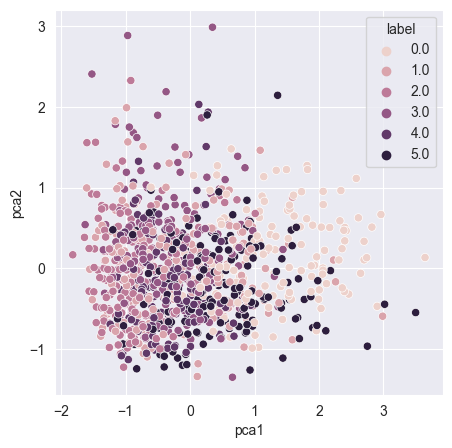

In [84]:
sns.set_palette('deep')
plt.figure(figsize=(5,5))
sns.scatterplot(x='pca1', y='pca2', hue='label', data=result_df.iloc[:1000,:])
plt.show()

### Other Features

In [85]:
data_adj = torch.cat([features, labels],axis=1)
data_adj = pd.DataFrame(data_adj.numpy())
data_corr = data_adj.corr().iloc[-1:,:-1].abs()
data_corr.columns = ['zcr_mean', 'zcr_std', 'zcr_max', 'zcr_min',
                     'pitch_mean', 'pitch_std', 'pitch_max', 'pitch_min', 'duration',
                     'energy_mean', 'energy_std', 'energy_max', 'energy_min',]
data_corr

,zcr_mean,zcr_std,zcr_max,zcr_min,pitch_mean,pitch_std,pitch_max,pitch_min,duration,energy_mean,energy_std,energy_max,energy_min
13,0.123878,0.092229,0.110024,0.027916,0.198727,0.201313,0.043485,NaN,0.148618,0.300999,0.306788,0.308991,0.010536


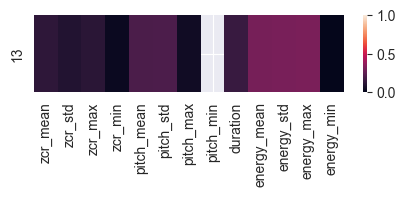

In [86]:
sns.set_palette('deep')
plt.figure(figsize=(5,1))
sns.heatmap(data_corr, vmax=1, vmin=0)
plt.show()

### Set Datasets

In [87]:
datasets = torch.cat([features, mfcc_features, mel_features, labels], axis=1)
torch.save(datasets, './datasets/tabula_data.pt')
torch.save(mfcc, './datasets/mfcc_use_tabula_data.pt')
torch.save(mel, './datasets/mel_use_tabula_data.pt')